In [1]:
import numpy as np
!pip install cantera CoolProp
!pip install --no-deps git+https://github.com/davetew/Modern-Aerospace-Propulsion.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 42.5 MB/s eta 0:00:00
  Cloning https://github.com/davetew/Modern-Aerospace-Propulsion.git to /tmp/pip-req-build-ncg5nf2j
  Running command git clone --filter=blob:none --quiet https://github.com/davetew/Modern-Aerospace-Propulsion.git /tmp/pip-req-build-ncg5nf2j
  Resolved https://github.com/davetew/Modern-Aerospace-Propulsion.git to commit 179f6b4008c4c8c2c5e19aa1d690d66cc17992f6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for modern-aerospace-propulsion: filename=modern_aerospace_propulsion-0.1.0-py3-none-any.whl size=32474 sha256=6c54d3ac270faa909536a3caa282bd6ea82cd87d9f80c059b59926c99a

In [2]:
def cstar(m_dot):
  p0 = 30e6
  a_t = 0.03898
  return p0*a_t / m_dot #N/m^2 * m^2/ (kg/s)

from modern_aerospace_propulsion.ffsc_nozzle import thermo, regen, cycle, sweep

# === Engine input parameters ===
OF = 3.8            # Oxidizer-to-fuel ratio, typical for CH4/O2 FFSC
p0 = 30e6           # Chamber pressure (Pa), 25 MPa

# Calculate the chamber state with Cantera
T, y, R, _ = thermo.cantera_chamber_state(OF=OF, p0=p0)

cstar_theory = np.sqrt(y*R*T)/ (y*(2/(y+1))**((y+1)/(2*y-2)))
print(cstar_theory)

n_cstar = cstar(770)/cstar_theory
print(n_cstar)

1817.8942063931165
0.8354178661004447


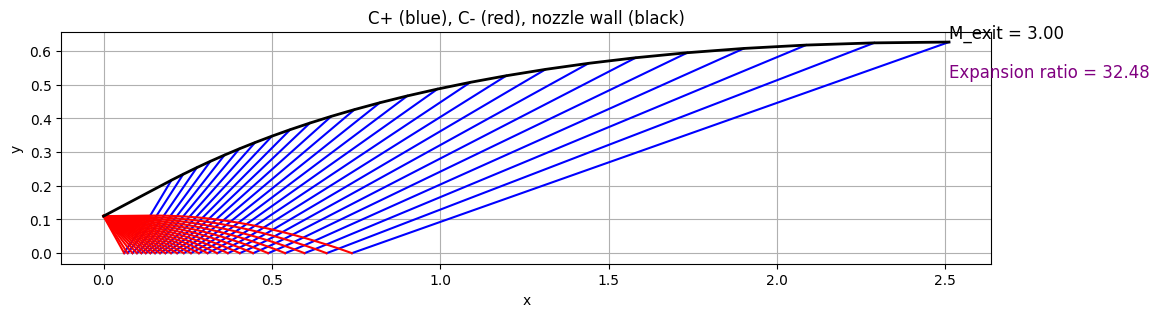

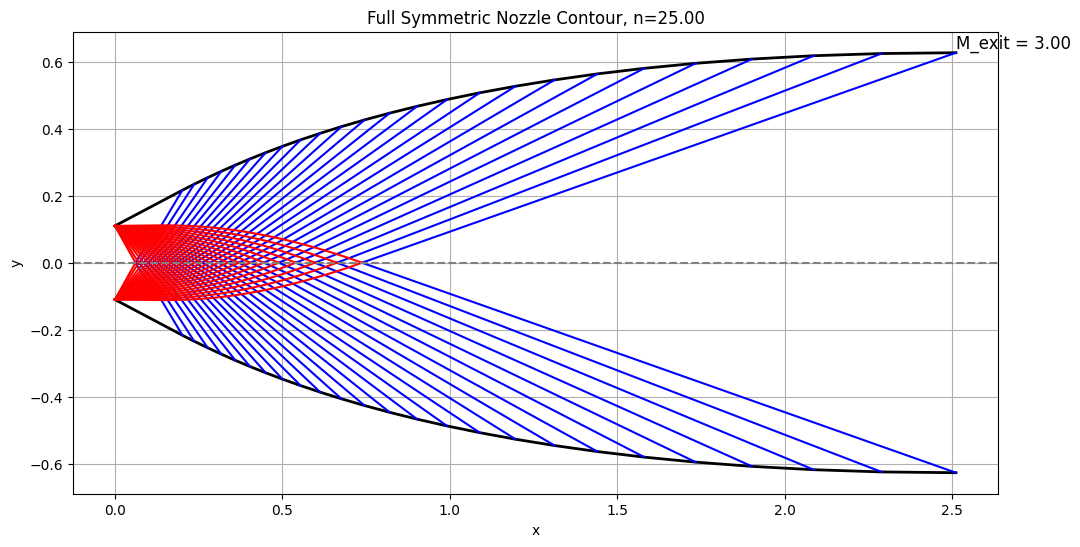

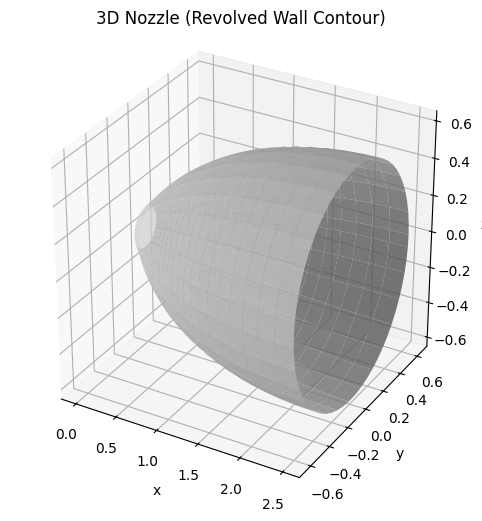

In [3]:
import numpy as np
import matplotlib.pyplot as plt


#Input parameters
M_ex=3
n=25
r=0.22/2 #throat radius
gamma=1.22

def P_M(M):
    a=np.sqrt((gamma+1)/(gamma-1))
    b=np.atan(np.sqrt((gamma-1)/(gamma+1)*(M**2-1)))
    c=np.atan(np.sqrt(M**2-1))
    return(a*b-c)

def P_M_inv(P):
    M_low=1
    M_high=10
    for i in range(100):
        M_mid=0.5*(M_low+M_high)
        P_mid=P_M(M_mid)
        if P_mid<P:
            M_low=M_mid
        else:
            M_high=M_mid
    return(M_mid)

def mu(M):
    return(np.asin(1/M))

def K_plus(theta,P_M):
    return(theta-P_M)

def K_minus(theta,P_M):
    return(theta+P_M)

def theta_K(K_plus,K_minus):
    return(0.5*(K_plus+K_minus))

def P_M_K(K_plus,K_minus):
    return(0.5*(K_minus-K_plus))

import sympy as sp
import math

def solve_system(xa, ya, xb, yb, theta, theta_a, theta_b, mu, mu_a, mu_b):
    X, Y = sp.symbols('X Y', real=True)
    m1 = math.tan((theta_a + theta)/2 - (mu_a + mu)/2)
    m2 = math.tan((theta_b + theta)/2 + (mu_b + mu)/2)
    eq1 = (Y - ya) - m1*(X - xa)
    eq2 = (Y - yb) - m2*(X - xb)
    sol = sp.solve((eq1, eq2), (X, Y))
    return sol

def wall_system(xa, ya, xb, yb, theta, theta_a, mu):
    X, Y = sp.symbols('X Y', real=True)
    m1 = (theta+theta_a)/2
    m2 = math.tan(theta + mu)
    eq1 = (Y - ya) - m1*(X - xa)
    eq2 = (Y - yb) - m2*(X - xb)
    sol = sp.solve((eq1, eq2), (X, Y))
    return sol



# a point A is defined by A=[theta,prandtl_meyer angle,mach number,mu angle,x,y]
#point a
x_a=0
y_a=r

theta_a_max=0.5*P_M(M_ex)
theta_a=np.array([theta_a_max*i/n for i in range(1,n+1)])
M_a=[P_M_inv(i) for i in theta_a]
mu_a=[mu(i) for i in M_a]
a=[[theta_a[i],theta_a[i],M_a[i],mu_a[i],x_a,y_a] for i in range(len(theta_a))]





def inter(a,b):  #a is the point on the C_ and b on the C+
    c=[0,0,0,0,0,0]
    Kp=K_plus(b[0],b[1])
    Km=K_minus(a[0],a[1])
    c[0]=(Kp+Km)/2
    c[1]=(Km-Kp)/2
    c[2]=P_M_inv(c[1])
    c[3]=mu(c[2])
    c[4],c[5]=solve_system(a[4],a[5],b[4],b[5],c[0],a[0],b[0],c[3],a[3],b[3]).values()
    return(c)

def ref(a):     # a is the point on the C_ before
    b=[0,0,0,0,0,0]
    b[1]=K_minus(a[0],a[1])
    b[2]=P_M_inv(b[1])
    b[3]=mu(b[2])
    m=np.tan(b[0]-b[3])
    b[4]=-a[5]/m+a[4]
    return(b)

def wall(a,b):     #a is the point wall befor and b the point on the C+
    c=[0,0,0,0,0,0]
    c[0]=b[0]
    c[1]=b[1]
    c[2]=b[2]
    c[3]=b[3]
    c[4],c[5]=wall_system(a[4],a[5],b[4],b[5],c[0],a[0],c[3]).values()
    return(c)

#point1
theta_1=0
P_M_1=theta_a[0]+P_M(M_a[0])
M_1=P_M_inv(P_M_1)
mu_1=mu(M_1)
m_1=np.tan(theta_1 - mu_1)
x_1=-y_a/m_1
y_1=0
p_1=[theta_1,P_M_1,M_1,mu_1,x_1,y_1]
C_p=[[p_1]]
for i in range(n):
    if i==0:
        for j in range(n-1):
            C_p[i].append(inter(a[j+1], C_p[i][j]))
        C_p[0].append(wall(a[-1],C_p[0][-1]))
    else:
        C_p.append([ref(C_p[-1][1])])
        for j in range(1, n-i):
            C_p[i].append(inter(C_p[i-1][j+1], C_p[i][j-1]))
        C_p[i].append(wall(C_p[i-1][-1],C_p[i][-1]))



plt.figure(figsize=(12,6))

# Plot C+ lines (along each row)
for row in C_p:
    xs = [P[4] for P in row]
    ys = [P[5] for P in row]
    plt.plot(xs, ys, color="blue")

# Plot C- lines (starting from throat point a)

for k in range(n):
    xs = [x_a]
    ys = [y_a]
    for i in range(0, k+1):
        if i < len(C_p) and (k - i) < len(C_p[i]) - 1:
            P = C_p[i][k - i]
            xs.append(P[4])
            ys.append(P[5])
    if len(xs) > 1:
        plt.plot(xs, ys, color="red")

wall_x = [x_a] + [row[-1][4] for row in C_p]
wall_y = [y_a] + [row[-1][5] for row in C_p]
plt.plot(wall_x, wall_y, color="black", linewidth=2)


M_exit = C_p[-1][-1][2]     # Mach number of last wall point
x_exit = wall_x[-1]
y_exit = wall_y[-1]
epsilon = (y_exit / r)**2
plt.text(x_exit, y_exit, f"M_exit = {M_exit:.2f}", fontsize=12, color="black",
         ha='left', va='bottom')
plt.text(x_exit, y_exit - 0.1*y_exit, f"Expansion ratio = {epsilon:.2f}", fontsize=12, color="purple",
         ha='left', va='top')

plt.xlabel("x")
plt.ylabel("y")
plt.title("C+ (blue), C- (red), nozzle wall (black)")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

plt.figure(figsize=(12,6))

# Upper wall
wall_x = [x_a] + [row[-1][4] for row in C_p]
wall_y = [y_a] + [row[-1][5] for row in C_p]

plt.plot(wall_x, wall_y, color="black", linewidth=2)

# Lower wall (symmetry)
wall_y_sym = [-y for y in wall_y]
plt.plot(wall_x, wall_y_sym, color="black", linewidth=2)
# Plot C+ (blue) upper
for row in C_p:
    xs = [P[4] for P in row]
    ys = [P[5] for P in row]
    plt.plot(xs, ys, color="blue")

# Plot C+ (blue) lower symmetric
for row in C_p:
    xs = [P[4] for P in row]
    ys = [-P[5] for P in row]
    plt.plot(xs, ys, color="blue")

# Plot C- (red) upper
for k in range(n):
    xs = [x_a]
    ys = [y_a]
    for i in range(0, k+1):
        if i < len(C_p) and (k - i) < len(C_p[i]) - 1:
            P = C_p[i][k - i]
            xs.append(P[4])
            ys.append(P[5])
    if len(xs) > 1:
        plt.plot(xs, ys, color="red")

# Plot C- (red) lower symmetric
for k in range(n):
    xs = [x_a]
    ys = [-y_a]
    for i in range(0, k+1):
        if i < len(C_p) and (k - i) < len(C_p[i]) - 1:
            P = C_p[i][k - i]
            xs.append(P[4])
            ys.append(-P[5])
    if len(xs) > 1:
        plt.plot(xs, ys, color="red")

# Centerline
plt.axhline(0, color="gray", linestyle="--")

plt.text(x_exit, y_exit, f"M_exit = {M_exit:.2f}", fontsize=12, color="black",
         ha='left', va='bottom')



plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Full Symmetric Nozzle Contour, n={n:.2f}")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


# 3D nozzle visualization
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

# Create revolution surface
theta_vals = np.linspace(0, 2*np.pi, 60)
X = []
Y = []
Z = []
for i in range(len(wall_x)):
    X.append(np.full_like(theta_vals, wall_x[i]))
    Y.append(wall_y[i]*np.cos(theta_vals))
    Z.append(wall_y[i]*np.sin(theta_vals))

X = np.array(X, dtype=float)
Y = np.array(Y, dtype=float)
Z = np.array(Z, dtype=float)

ax.plot_surface(X, Y, Z, color='lightgray', edgecolor='none', alpha=0.8)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('3D Nozzle (Revolved Wall Contour)')
ax.set_box_aspect([1,1,1])
plt.show()


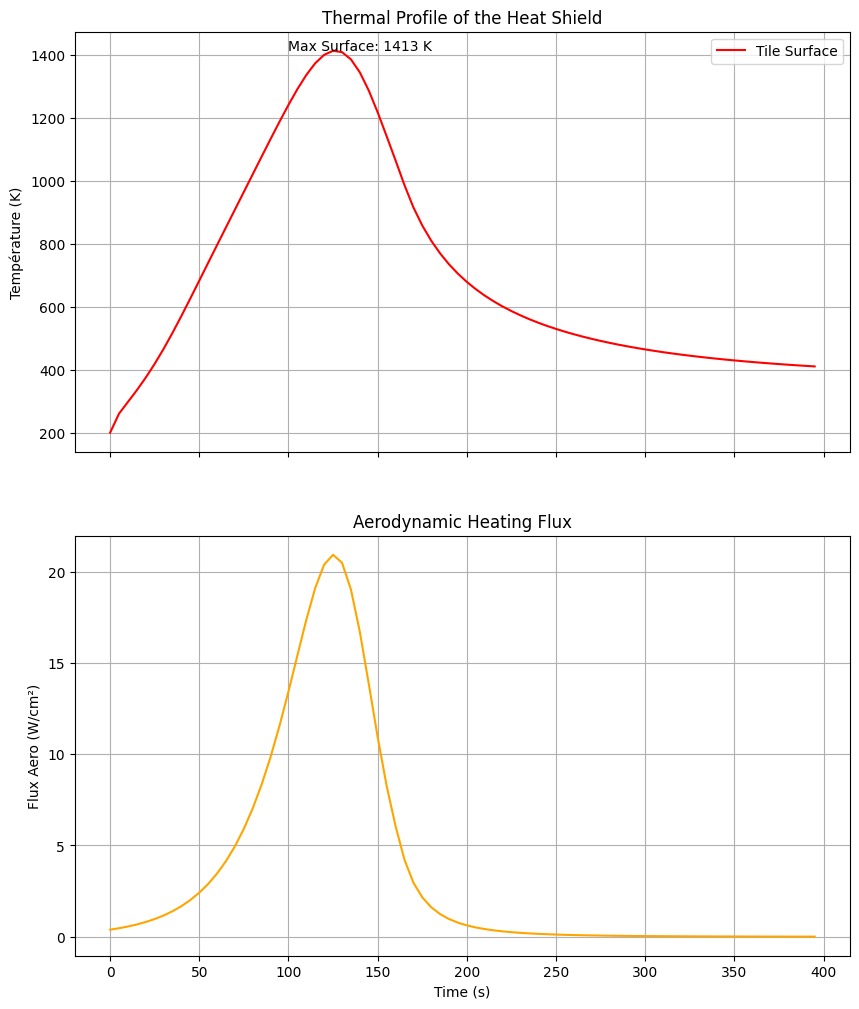

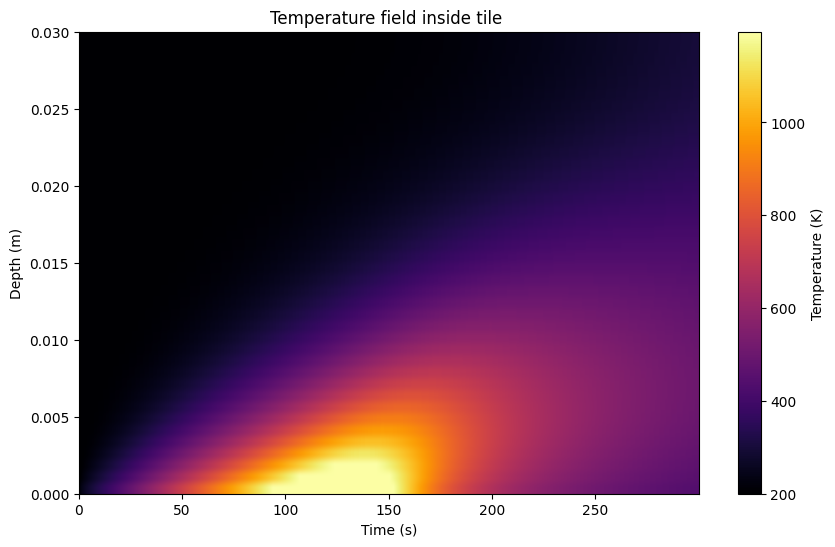

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. PHYSICAL & MATERIAL PARAMETERS
# ==========================================

# --- Tile properties (LI-900 / SpaceX Hex tile approximation) ---
thickness = 0.03       # Tile thickness (m) -> 5 cm
k_tile = 0.16          # Thermal conductivity (W/m.K) - very insulating
rho_tile = 144         # Density (kg/m3) - very light
cp_tile = 1200         # Specific heat capacity (J/kg.K)
epsilon = 0.85         # Emissivity of external surface (radiation)
T_space = 150        # Effective radiative background temperature (deep space / IR)

# --- Propriétés de l'Acier (Structure derrière la tuile) ---
# On ne modélise pas l'épaisseur de l'acier, juste la température de l'interface

# --- Martian atmosphere & geometry ---
Rn = 4.0               # Effective belly curvature radius of Starship (m)
rho_surface_mars = 0.020 # Mars surface density (kg/m3)
H_scale_mars = 11100   # Atmospheric scale height (m)
g_mars = 3.71          # Gravity (m/s2)
C_sutton = 1.9e-4      # Constante de Sutton-Graves (adaptée pour CO2 approx)

# --- Conditions Initiales d'Entrée ---
V_entry = 4000         # Vitesse d'entrée (m/s) - Typique Mars direct
gamma = -12 * (np.pi/180) # Entry angle (degrees → radians)
alt = 120000           # Altitude de début (m)
T_initial = 200        # Initial tile temperature (K)

# ==========================================
# 2. DISCRÉTISATION (MÉTHODE DES DIFFÉRENCES FINIES)
# ==========================================
Nx = 20                # Number of points across tile thickness
dx = thickness / (Nx - 1)
x_grid = np.linspace(0, thickness, Nx)

dt = 0.05              # Time step (s) – must be small for stability
t_max = 400            # Simulation duration (s)
Nt = int(t_max / dt)

# Temperature array T[x]
T = np.ones(Nx) * T_initial

# Data history storage
history_t = []
history_V = []
history_alt = []
history_q_aero = []
history_T_surf = [] # Température face externe
history_T_back = [] # Température interface acier (face interne)
history_T_field = []  # Complete temperature profiles in the tile

# Propriétés thermo variables (Simplification: on garde k et cp constants ici pour lisibilité)
# En réalité, k et cp changent avec T, mais pour une "petite simulation", c'est acceptable.
alpha = k_tile / (rho_tile * cp_tile) # Diffusivité thermique

# Stability check (Critère de Fourier)
Fo = alpha * dt / (dx**2)
if Fo > 0.5:
    print(f"ATTENTION: Instabilité numérique! Fo={Fo:.2f} > 0.5")
    print("Réduisez dt ou augmentez Nx.")
    exit()

# ==========================================
# TIME LOOP
# ==========================================
V = V_entry
current_alt = alt
sigma = 5.67e-8  # Stefan-Boltzmann

for n in range(Nt):
    # --- A. Dynamique de vol (Trajectoire balistique simple) ---
    # Local atmospheric density
    rho = rho_surface_mars * np.exp(-current_alt / H_scale_mars)

    # Drag force : F = 0.5 * rho * V^2 * Cd * A
    # Décélération : a = F/m = 0.5 * rho * V^2 * (Cd*A/m)
    # Coefficient balistique (Beta = m/CdA). Pour Starship ~ 500-800 kg/m2
    Beta = 600
    drag_accel = 0.5 * rho * V**2 / Beta

    # Update velocity and altitude
    dV = -drag_accel * dt + g_mars * np.sin(gamma) * dt
    V += dV
    if V < 0: V = 0 # Stop at ground

    dAlt = V * np.sin(gamma) * dt
    current_alt += dAlt
    if current_alt < 0: current_alt = 0

    # --- B. Compute aerodynamic heating flux ---
    # Formule Sutton-Graves : q = C * sqrt(rho/Rn) * V^3
    q_conv = C_sutton * np.sqrt(rho / Rn) * (V**3)

    # --- C. Thermal resolution (1D finite differences) ---
    T_new = T.copy()

    # 1. Intérieur de la tuile (Conduction pure)
    for i in range(1, Nx - 1):
        T_new[i] = T[i] + Fo * (T[i+1] - 2*T[i] + T[i-1])

    # 2. External surface (i=0): Net flux = convection – radiation → conduction
    q_rad = epsilon * sigma * (T[0]**4 - T_space**4)
    q_net = q_conv - q_rad

    # Condition aux limites de Neumann discrétisée
    T_new[0] = T[0] + 2*Fo*(T[1] - T[0] + (dx/k_tile)*q_net)

    # 3. Surface Interne / Acier (i=Nx-1) : Adiabatique (Isolée)
    # Assumption: internally adiabatic (worst case).
    T_new[-1] = T[-1] + 2*Fo*(T[-2] - T[-1])

    # Mise à jour
    T = T_new

    # --- D. Store data ---
    if n % 100 == 0: # On n'enregistre pas à chaque pas pour alléger
        history_t.append(n * dt)
        history_V.append(V)
        history_alt.append(current_alt)
        history_q_aero.append(q_conv/10000) # En W/cm2 pour lisibilité ou juste scaled
        history_T_surf.append(T[0])
        history_T_back.append(T[-1])
        history_T_field.append(T.copy())

# ==========================================
# 4. AFFICHAGE RÉSULTATS
# ==========================================
fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Trajectoire


# Températures

ax2.plot(history_t, history_T_surf, 'r-', label="Tile Surface")
#ax2.plot(history_t, history_T_back, 'k--', label="Structure Acier (Interne)")
ax2.set_ylabel("Température (K)")
ax2.set_title("Thermal Profile of the Heat Shield")
ax2.legend()
ax2.grid(True)
ax2.annotate(f'Max Surface: {max(history_T_surf):.0f} K', xy=(100, max(history_T_surf)))

# Flux de chaleur
ax3.plot(history_t, history_q_aero, 'orange')
ax3.set_ylabel("Flux Aero (W/cm²)") # Scaling arbitraire pour la forme
ax3.set_xlabel("Time (s)")
ax3.set_title("Aerodynamic Heating Flux")
ax3.grid(True)
import numpy as np

def solve_heat_equation(
    thickness,
    Nx,
    dt,
    t_max,
    k,
    rho,
    cp,
    q_conv_func,
    epsilon=0.85,
    T_space=150,
    T_init=200,
):
    """
    Résout l'équation de la chaleur 1D dans la tuile :
        dT/dt = alpha * d²T/dx²
    avec :
        - flux imposé au bord externe (conv + rad)
        - condition adiabatique au bord interne (pire cas)

    q_conv_func(t) doit retourner le flux convectif au temps t.
    """

    alpha = k / (rho * cp)
    dx = thickness / (Nx - 1)
    Fo = alpha * dt / dx**2

    if Fo > 0.5:
        print(f"WARNING: Fo={Fo:.3f} > 0.5 instable !")

    # Grille spatiale
    x = np.linspace(0, thickness, Nx)

    # État thermique
    T = np.ones(Nx) * T_init

    # Historique complet du champ
    Nt = int(t_max / dt)
    T_field = np.zeros((Nt, Nx))
    time = np.zeros(Nt)

    sigma = 5.67e-8

    for n in range(Nt):
        t = n * dt
        time[n] = t

        q_conv = q_conv_func(t)
        T_new = T.copy()

        # Intérieur : conduction pure
        for i in range(1, Nx - 1):
            T_new[i] = T[i] + Fo * (T[i+1] - 2*T[i] + T[i-1])

        # Bord externe (x=0)
        q_rad = epsilon * sigma * (T[0]**4 - T_space**4)
        q_net = q_conv - q_rad
        T_new[0] = T[0] + 2 * Fo * (T[1] - T[0] + dx * q_net / k)

        # Bord interne adiabatique (x=e)
        T_new[-1] = T[-1] + 2 * Fo * (T[-2] - T[-1])

        # Mise à jour
        T = T_new.copy()
        T_field[n] = T

    return time, x, T_field

# On définit le flux entrant en fonction du temps (interpolation des données calculées)
def q_conv_of_time(t):
    if len(history_t) < 2:
        return 0.0
    return np.interp(t, history_t, np.array(history_q_aero) * 1e4)  # Converti W/cm2 -> W/m2


time, x, T_field = solve_heat_equation(
    thickness=0.03,
    Nx=40,
    dt=0.02,
    t_max=300,
    k=0.08,
    rho=144,
    cp=1200,
    q_conv_func=q_conv_of_time,
)

plt.figure(figsize=(10,6))
plt.imshow(
    T_field.T,
    aspect='auto',
    origin='lower',
    extent=[0, time[-1], 0, thickness],
    cmap='inferno',
    vmin = np.percentile(T_field, 1),   # ignore le bruit très froid
    vmax = np.percentile(T_field, 99)   # Reduce saturation for better visibility
)
plt.colorbar(label="Temperature (K)")
plt.title("Temperature field inside tile ")
plt.xlabel("Time (s)")
plt.ylabel("Depth (m)")

plt.show()